# **Sentiment Analysis - Amazon food review**

**Objective**

Amazon is an international e-commerce giant with massive portfolio of products offered online, ranging from electronics to fresh produce. Even though being the pioneer in the e-retail market, it has created a treasure trove of reviews for its products.
The goal is to develop an automated text-based classification system, that can accurately predict the sentiments of Amazon online consumer reviews. The study has to be conducted on the data collected from Amazon.com consisting of reviews on fine food. The model will take reviews in as input. It will then come up with a prediction on whether the review is positive, negative, or neutral.


The dataset used for this project is available at Kaggle https://www.kaggle.com/snap/amazon-fine-food-reviews

**Models to solve the problem**

The models used to solve the problem "Naive Bayes" , "Logistic regression" and 

Long short-term memory (LSTM). 

LSTM has the highest accuracy and f1- score:
**********************************************************
*****************  Classification Report  ****************
**********************************************************
              precision    recall  f1-score   support

           0       0.71      0.79      0.75     40666
           1       0.95      0.92      0.93    218871
           2       0.46      0.52      0.49     20844

    accuracy                           0.87    280381
   macro avg       0.71      0.74      0.72    280381
weighted avg       0.88      0.87      0.87    280381




**Naive Bayes**
The Naive Bayes text classification algorithm is a type of probabilistic model used in machine learning. It has become one of the most popular and effective classification methods for Text classification. The algorithm is fast and easy to use and helps in predicting the class of a dataset very quickly.
The metrices of the models were:
**********************************************************
*****************  Classification Report  ****************
**********************************************************
              precision    recall  f1-score   support

           0       0.64      0.70      0.67     16221
           1       0.94      0.83      0.88     87527
           2       0.24      0.49      0.32      8405

    accuracy                           0.79    112153
   macro avg       0.61      0.68      0.62    112153
weighted avg       0.84      0.79      0.81    112153

**Logistic Regressions**
**********************************************************
*****************  Classification Report  ****************
**********************************************************
              precision    recall  f1-score   support

           0       0.67      0.76      0.71     16221
           1       0.95      0.87      0.91     87527
           2       0.31      0.51      0.39      8405

    accuracy                           0.82    112153
   macro avg       0.64      0.71      0.67    112153
weighted avg       0.86      0.82      0.84    112153

In [2]:
# Load packages
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from collections import Counter

import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm
from keras.utils import pad_sequences
from keras import mixed_precision
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from nltk import FreqDist
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM, Dense, Embedding, Bidirectional

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# Methods 

# This function classify a review score > 3 as 1 (positive) and a score < 3 as 0 (negative) and == 3 as 2 (neutral)
def score_classification(score):
    
    if score > 3:
        return 1
    elif score == 3:
        return 2
    else:
        return 0

# Generate word cloud
def generate_word_cloud(Text):
    wordcloud = WordCloud(
        background_color='white',
        width = 1000,
        height = 500).generate(str(Text))
    fig = plt.figure(
        figsize = (10, 6),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

In [4]:
#Load the review data
dfreviews=pd.read_csv('/content/drive/MyDrive/Reviews.csv')
dfreviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
#Check the shape of review dataset
dfreviews.shape

(568454, 10)

Data has 568454 rows and 10 columns, including productId, userId, review helpfulness score, score, timestamp (unix timestamp) and the review itself in one or multiple sentences.

* Id: Index of user in the system
* ProductId: Unique code associated with each product
* UserId: Unique code associated with each user
* HelpfulnessNumerator: number of uers finding review helpful
* HelpfulnessDenominator: number of users checking the review
* Time: Unix time stamp of review
* Summary: title of the review
* Text: review text

There are 10 features and 568454 records in the reviews dataset.

In [6]:
# Check columns in review dataset 
dfreviews.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [7]:
# Check datatype for all the columns 
dfreviews.dtypes

Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object

In [8]:
# Check the number of null values in the dataset 
dfreviews.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

There are null values in 'ProfileName' and 'Summary' features. 'ProfileName' has 16 null values and 'Summary' has 27 null values. Dropping those records having null values will not make impact of the database. 
Because the count of null values are very small we will drop them from the dataset.

**Sample review from the dataset**

In [9]:
# Review text of 18th record
dfreviews['Text'][18]

'Twizzlers, Strawberry my childhood favorite candy, made in Lancaster Pennsylvania by Y & S Candies, Inc. one of the oldest confectionery Firms in the United States, now a Subsidiary of the Hershey Company, the Company was established in 1845 as Young and Smylie, they also make Apple Licorice Twists, Green Color and Blue Raspberry Licorice Twists, I like them all<br /><br />I keep it in a dry cool place because is not recommended it to put it in the fridge. According to the Guinness Book of Records, the longest Licorice Twist ever made measured 1.200 Feet (370 M) and weighted 100 Pounds (45 Kg) and was made by Y & S Candies, Inc. This Record-Breaking Twist became a Guinness World Record on July 19, 1998. This Product is Kosher! Thank You'

In [10]:
# Summary of 18th record
dfreviews['Summary'][18]

'GREAT SWEET CANDY!'

The Summary for a review does not contain much text. So, the 'Text' and 'Summary' features could be combined to have all the text in new feature 'Summary_text'. This step we will perform during feature engineering.

# **Data pre-processing**

**Remove null values**

In [11]:
# check null values again before dropping them
dfreviews.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [12]:
# Null values are dropped 
dfreviews.dropna(inplace=True)
dfreviews.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [13]:
# Remove the unwanted features like Id and ProfileName.
dfreviews.drop(['Id','ProfileName'],axis=1, inplace=True)
dfreviews.head()

,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,B001E4KFG0,A3SGXH7AUHU8GW,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


**Join Summary and Text**


Join the content of 'Summary' and 'Text' features and add a new feature as 'Summary_Text'.  In this way the new feature will have the combined text and we can drop 'Summary' and 'Text' features from the dataset.

In [14]:
# Converting columns to string type
dfreviews.Text=dfreviews.Text.apply(str)
dfreviews.Summary=dfreviews.Summary.apply(str)

dfreviews['Summary_Text']=dfreviews[['Summary','Text']].agg(' '.join, axis=1)
dfreviews.head()

,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Summary_Text
0,B001E4KFG0,A3SGXH7AUHU8GW,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Good Quality Dog Food I have bought several of...
1,B00813GRG4,A1D87F6ZCVE5NK,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised Product arrived labeled as J...
2,B000LQOCH0,ABXLMWJIXXAIN,1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,"""Delight"" says it all This is a confection tha..."
3,B000UA0QIQ,A395BORC6FGVXV,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Cough Medicine If you are looking for the secr...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Great taffy Great taffy at a great price. The...


In [15]:
# Drop Text and Summary column
dfreviews.drop(['Text','Summary'],axis=1, inplace=True)
dfreviews.head()

,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary_Text
0,B001E4KFG0,A3SGXH7AUHU8GW,1,1,5,1303862400,Good Quality Dog Food I have bought several of...
1,B00813GRG4,A1D87F6ZCVE5NK,0,0,1,1346976000,Not as Advertised Product arrived labeled as J...
2,B000LQOCH0,ABXLMWJIXXAIN,1,1,4,1219017600,"""Delight"" says it all This is a confection tha..."
3,B000UA0QIQ,A395BORC6FGVXV,3,3,2,1307923200,Cough Medicine If you are looking for the secr...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,0,0,5,1350777600,Great taffy Great taffy at a great price. The...


**Converting the Unix time to date**

In [16]:
# converting unix time to year/month/day format
dfreviews['Time_ymd']=dfreviews['Time'].apply(lambda col: datetime.utcfromtimestamp(int(col)).strftime('%Y-%m-%d'))

# converting unix time to year/month format
dfreviews['Time_ym']=dfreviews['Time'].apply(lambda col: datetime.utcfromtimestamp(int(col)).strftime('%Y-%m'))

# Drop Time column
dfreviews.drop(['Time'] ,axis=1, inplace=True)
dfreviews.head()

,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary_Text,Time_ymd,Time_ym
0,B001E4KFG0,A3SGXH7AUHU8GW,1,1,5,Good Quality Dog Food I have bought several of...,2011-04-27,2011-04
1,B00813GRG4,A1D87F6ZCVE5NK,0,0,1,Not as Advertised Product arrived labeled as J...,2012-09-07,2012-09
2,B000LQOCH0,ABXLMWJIXXAIN,1,1,4,"""Delight"" says it all This is a confection tha...",2008-08-18,2008-08
3,B000UA0QIQ,A395BORC6FGVXV,3,3,2,Cough Medicine If you are looking for the secr...,2011-06-13,2011-06
4,B006K2ZZ7K,A1UQRSCLF8GW1T,0,0,5,Great taffy Great taffy at a great price. The...,2012-10-21,2012-10


In [17]:
# The earliest and latest review dates
print('Earliest review - ', dfreviews['Time_ymd'].min())
print('Latest review - ', dfreviews['Time_ymd'].max()) 

Earliest review -  1999-10-08
Latest review -  2012-10-26


**Calculate Helpfulness Ratio**

Calculate ratio of helpfulness and add a new feature 'Helpfulness Ratio'. The retio will tell the average number of people finding review helpful over number of users checking the review.
* HelpfulnessNumerator: number of uers finding review helpful
* HelpfulnessDenominator: number of users checking the review

In [18]:
# Calculate Helpfulness Ratio where 'HelpfulnessDenominator' > 0, otherwise put -1

dfreviews['Helpfulness Ratio'] = np.where(dfreviews['HelpfulnessDenominator'] > 0, dfreviews['HelpfulnessNumerator'] / dfreviews['HelpfulnessDenominator'], -1)

# Drop HelpfulnessNumerator, HelpfulnessDenominator 
dfreviews.drop(['HelpfulnessNumerator', 'HelpfulnessDenominator'], axis=1, inplace=True)
dfreviews.head()

,ProductId,UserId,Score,Summary_Text,Time_ymd,Time_ym,Helpfulness Ratio
0,B001E4KFG0,A3SGXH7AUHU8GW,5,Good Quality Dog Food I have bought several of...,2011-04-27,2011-04,1.0
1,B00813GRG4,A1D87F6ZCVE5NK,1,Not as Advertised Product arrived labeled as J...,2012-09-07,2012-09,-1.0
2,B000LQOCH0,ABXLMWJIXXAIN,4,"""Delight"" says it all This is a confection tha...",2008-08-18,2008-08,1.0
3,B000UA0QIQ,A395BORC6FGVXV,2,Cough Medicine If you are looking for the secr...,2011-06-13,2011-06,1.0
4,B006K2ZZ7K,A1UQRSCLF8GW1T,5,Great taffy Great taffy at a great price. The...,2012-10-21,2012-10,-1.0


**Drop duplicate records**

In [19]:
# Check the number of duplicate records by grouping the data on UserId and ProductId
dfreviews[dfreviews.duplicated(['UserId','ProductId'])].count()

ProductId            7650
UserId               7650
Score                7650
Summary_Text         7650
Time_ymd             7650
Time_ym              7650
Helpfulness Ratio    7650
dtype: int64

A look at the data reveal that there are over 7650 entries that are repeated.  The duplicate records need to be cleaned.


In [20]:
# Dataset shape before dropping duplicate records
print('Initial shape')
dfreviews.shape

Initial shape


(568411, 7)

In [21]:
# Droppping duplicate records and keeping the latest one per group
dfreviews=dfreviews.drop_duplicates(subset=['UserId','ProductId'], keep='last', inplace=False)

# Check if the duplicates are still there
dfreviews[dfreviews.duplicated(['UserId','ProductId'])].count()

ProductId            0
UserId               0
Score                0
Summary_Text         0
Time_ymd             0
Time_ym              0
Helpfulness Ratio    0
dtype: int64

There are no duplicate records exist in dataset.

In [22]:
print('Shape after removing duplicate review')
dfreviews.shape

Shape after removing duplicate review


(560761, 7)

Initial dataset shape was (568411, 10) and Shape after removing duplicate review is
(560761, 10). Almost 7650 duplicate records are removed.

#**Text Cleaning**

The steps to clean the text are: 
1. Filtering reviews for punctuation, html tags, and links.
2. Remove special characters like '/', '*', and '@'.
3. Filtering Stop Words - words like in', 'is', and 'an' are often used as stop words since they don’t add a lot of meaning to a text. There are some words like 'amazon', 'product', 'good' ,and 'great' added as stop words because these are common words in all the reviews.
4. Remove words having less than 3 characters. Words like 'the', 'he', and 'she'.




In [23]:
import re 
import string

punctuation =  set(string.punctuation)
stop_words = set(stopwords.words("english"))
stop_words.update(["br", "href","good","great","amazon","product", "counter"])

def Clean_Text(review):
  x = review
  x = re.sub(r'https?:\S*', '', x)
  x = re.sub(r'{link}', '', x) #remove links
  x = re.sub(r'@[\w]*', '', x) 
  x = re.sub(r'[^A-Za-z0-9]+', ' ', x)
  x = re.sub(r'\b[0-9]+\b', '', x)
  x = re.sub(r'&[a-z]+', '', x)
  x = ''.join(w for w in x if w not in punctuation)
  x = x.replace('[^a-zA-Z#]',' ') # Remove special 
  
  x = [w.lower() for w in x.split() if w.lower() not in stop_words]
  x = [w for w in x if len(w) > 3]
  return x

In [24]:
# Apply the clean text on all reviews
dfreviews['Text_new']  = dfreviews['Summary_Text'].apply(lambda x: Clean_Text(x))
dfreviews.head()

,ProductId,UserId,Score,Summary_Text,Time_ymd,Time_ym,Helpfulness Ratio,Text_new
0,B001E4KFG0,A3SGXH7AUHU8GW,5,Good Quality Dog Food I have bought several of...,2011-04-27,2011-04,1.0,"[quality, food, bought, several, vitality, can..."
1,B00813GRG4,A1D87F6ZCVE5NK,1,Not as Advertised Product arrived labeled as J...,2012-09-07,2012-09,-1.0,"[advertised, arrived, labeled, jumbo, salted, ..."
2,B000LQOCH0,ABXLMWJIXXAIN,4,"""Delight"" says it all This is a confection tha...",2008-08-18,2008-08,1.0,"[delight, says, confection, around, centuries,..."
3,B000UA0QIQ,A395BORC6FGVXV,2,Cough Medicine If you are looking for the secr...,2011-06-13,2011-06,1.0,"[cough, medicine, looking, secret, ingredient,..."
4,B006K2ZZ7K,A1UQRSCLF8GW1T,5,Great taffy Great taffy at a great price. The...,2012-10-21,2012-10,-1.0,"[taffy, taffy, price, wide, assortment, yummy,..."


In [25]:
#  A list of clean words is the output
print(dfreviews['Text_new'][18])

['sweet', 'candy', 'twizzlers', 'strawberry', 'childhood', 'favorite', 'candy', 'made', 'lancaster', 'pennsylvania', 'candies', 'oldest', 'confectionery', 'firms', 'united', 'states', 'subsidiary', 'hershey', 'company', 'company', 'established', 'young', 'smylie', 'also', 'make', 'apple', 'licorice', 'twists', 'green', 'color', 'blue', 'raspberry', 'licorice', 'twists', 'like', 'keep', 'cool', 'place', 'recommended', 'fridge', 'according', 'guinness', 'book', 'records', 'longest', 'licorice', 'twist', 'ever', 'made', 'measured', 'feet', 'weighted', 'pounds', 'made', 'candies', 'record', 'breaking', 'twist', 'became', 'guinness', 'world', 'record', 'july', 'kosher', 'thank']


#**Feature Engineering**

**Calculating review lenghts**

Length of review is calculated after cleaning review text to better understand the relationship of review text with helpfulness.

The average length of reviews is 35 words. Very few reviews has text length over 400 words.

In [26]:
# lenght of review calculated stored in new column
dfreviews['Text_lenght']  =dfreviews['Text_new'].apply(lambda review: len(review))

In [27]:
dfreviews['Text_lenght'].describe()

count    560761.000000
mean         35.568856
std          34.365835
min           0.000000
25%          16.000000
50%          25.000000
75%          43.000000
max        1835.000000
Name: Text_lenght, dtype: float64

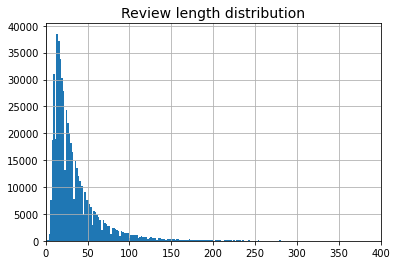

In [28]:
dfreviews['Text_lenght'].hist(bins=1000);
plt.xlim(0,400)
plt.title('Review length distribution',fontsize=14);

**A look at the review scores**

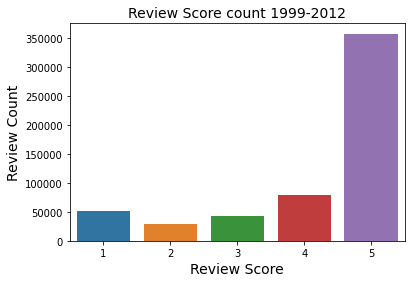

In [29]:
# plotting count of each review score
sns.countplot(x='Score', data=dfreviews);
plt.xlabel('Review Score',fontsize=14);
plt.ylabel('Review Count',fontsize=14);
plt.title('Review Score count 1999-2012',fontsize=14);
plt.savefig('review_score_count_1999_2012.png')

Ratio of reviews with score 5 are disproportional to the rest of reviews. This shows that the data is imbalanced.

To classify the reviews as positive/negative/neutral we have to add a new fetaure as 'Sentiment' as part of feature engineering.

All reviews with ‘Score’ greater than (>) 3 are considered positive and all reviews with ‘Score’ less than (<) 3 will be considered negative. Reviews with 'Score' equal to 3 are marked as neutral.

In [30]:
# Classify the reviews based on 'Score'
dfreviews['Sentiment']=dfreviews['Score'].apply(score_classification)
dfreviews.head()

,ProductId,UserId,Score,Summary_Text,Time_ymd,Time_ym,Helpfulness Ratio,Text_new,Text_lenght,Sentiment
0,B001E4KFG0,A3SGXH7AUHU8GW,5,Good Quality Dog Food I have bought several of...,2011-04-27,2011-04,1.0,"[quality, food, bought, several, vitality, can...",21,1
1,B00813GRG4,A1D87F6ZCVE5NK,1,Not as Advertised Product arrived labeled as J...,2012-09-07,2012-09,-1.0,"[advertised, arrived, labeled, jumbo, salted, ...",17,0
2,B000LQOCH0,ABXLMWJIXXAIN,4,"""Delight"" says it all This is a confection tha...",2008-08-18,2008-08,1.0,"[delight, says, confection, around, centuries,...",40,1
3,B000UA0QIQ,A395BORC6FGVXV,2,Cough Medicine If you are looking for the secr...,2011-06-13,2011-06,1.0,"[cough, medicine, looking, secret, ingredient,...",18,0
4,B006K2ZZ7K,A1UQRSCLF8GW1T,5,Great taffy Great taffy at a great price. The...,2012-10-21,2012-10,-1.0,"[taffy, taffy, price, wide, assortment, yummy,...",12,1


In [31]:
# Get the count of reviews under each class
dfreviews['Sentiment'].value_counts()

1    437629
0     81106
2     42026
Name: Sentiment, dtype: int64

Here again we can see that after classification, the data is not balanced for all three classes which we have to handle before using it for model training.

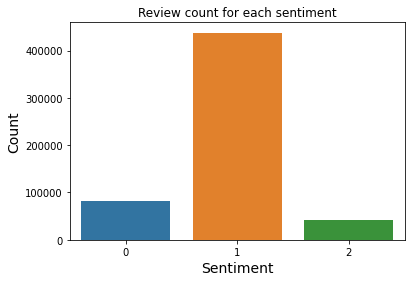

In [32]:
#Visualization of positive "1", negative "0" , and neutral "2" reviews
sns.countplot(x='Sentiment', data=dfreviews);
plt.xlabel('Sentiment',fontsize=14);
plt.ylabel('Count',fontsize=14);
plt.title('Review count for each sentiment');

In [33]:
# Check datatype for all the columns 
dfreviews.dtypes

ProductId             object
UserId                object
Score                  int64
Summary_Text          object
Time_ymd              object
Time_ym               object
Helpfulness Ratio    float64
Text_new              object
Text_lenght            int64
Sentiment              int64
dtype: object

#**Exploratory Data Analysis (EDA)**

**A look at top reviewer population (individuals with more than 10 reviews)**

* Top reviewers are group of users to have spent more time reviewing the products and expected to have more engagement with the readers. Impact of this engagement effectiveness is studied in terms of feedback they receive from the readers for their reviews.
* Individual with more than 10 review are in top review group, regardless of number of products.
* Total review count per each user is analyzed against their average review helpfulness,as well as average review length.

In [34]:
# total review per user is grouped
user_number_review=dfreviews.groupby(by=['UserId']).count().sort_values(by=['Text_new'],ascending=False)

user_number_review.head()

,ProductId,Score,Summary_Text,Time_ymd,Time_ym,Helpfulness Ratio,Text_new,Text_lenght,Sentiment
UserId,,,,,,,,,
A3OXHLG6DIBRW8,420,420,420,420,420,420,420,420,420
AY12DBB0U420B,382,382,382,382,382,382,382,382,382
A281NPSIMI1C2R,321,321,321,321,321,321,321,321,321
A1YUL9PCJR3JTY,309,309,309,309,309,309,309,309,309
A1Z54EM24Y40LL,251,251,251,251,251,251,251,251,251


In [35]:
# only individual with more than 10 review incuded in top group
user_top_reviewer=user_number_review[user_number_review['Text_new']>10][['Text_new']]
user_top_reviewer.head(10)

,Text_new
UserId,
A3OXHLG6DIBRW8,420
AY12DBB0U420B,382
A281NPSIMI1C2R,321
A1YUL9PCJR3JTY,309
A1Z54EM24Y40LL,251
A2MUGFV2TDQ47K,201
AQQLWCMRNDFGI,167
AZV26LP92E6WU,167
A1UQBFCERIP7VJ,157


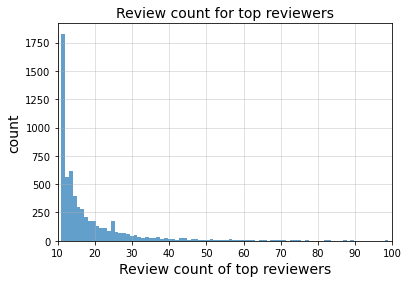

In [36]:
# distribution of review count per user

user_top_reviewer['Text_new'].hist(bins=400,label='Number of reviews for Top (>10) reviewer',alpha=0.7);
plt.xlabel('Review count of top reviewers',fontsize=14);
plt.ylabel('count',fontsize=14);

plt.grid(linewidth=0.5,alpha=0.75)

plt.xlim(10,100)
plt.title('Review count for top reviewers',fontsize=14);
plt.savefig('review_count_top_reviewer_dist.png')

In [37]:
user_top_reviewer['Text_new'].describe()

count    6104.000000
mean       19.759174
std        17.420741
min        11.000000
25%        12.000000
50%        15.000000
75%        21.000000
max       420.000000
Name: Text_new, dtype: float64

In [38]:
# getting average data per user
user_average_info=dfreviews.groupby(by=['UserId']).mean() 
user_average_info.head()

,Score,Helpfulness Ratio,Text_lenght,Sentiment
UserId,,,,
#oc-R103C0QSV1DF5E,5.0,0.5,16.0,1.0
#oc-R109MU5OBBZ59U,5.0,0.0,10.0,1.0
#oc-R10LFEMQEW6QGZ,5.0,0.0,52.0,1.0
#oc-R10LT57ZGIB140,3.0,-1.0,17.0,2.0
#oc-R10UA029WVWIUI,1.0,-1.0,26.0,0.0


On average top reviewers write about 20 reviews, with very few <1% write over 40 review

**Getting the average statistics for top reviewers**

In [39]:
# merging total review count and avg data per user
top_reviewer_avg_data=pd.merge(user_average_info,user_top_reviewer,how='inner',on='UserId')
top_reviewer_avg_data.head()

,Score,Helpfulness Ratio,Text_lenght,Sentiment,Text_new
UserId,,,,,
A100WO06OQR8BQ,3.109091,-0.247304,71.090909,0.727273,55
A101P2KHWCU0G6,2.038462,0.346154,132.153846,0.346154,26
A102LH0KD8SYHX,4.428571,0.285714,12.285714,1.285714,14
A102UXGLDF76G1,4.818182,-0.530303,35.727273,1.090909,11
A103U3KR4L2ZXT,5.000000,-0.454545,15.181818,1.000000,11


In [40]:
#making sure ratio of helpfulness between 0-1
top_reviewer_avg_data=top_reviewer_avg_data[(top_reviewer_avg_data['Helpfulness Ratio']>0.0) & (top_reviewer_avg_data['Helpfulness Ratio']<1.0)]
top_reviewer_avg_data.head()

,Score,Helpfulness Ratio,Text_lenght,Sentiment,Text_new
UserId,,,,,
A101P2KHWCU0G6,2.038462,0.346154,132.153846,0.346154,26
A102LH0KD8SYHX,4.428571,0.285714,12.285714,1.285714,14
A106ZCP7RSXMRU,4.630435,0.798810,51.500000,1.065217,46
A10AFVU66A79Y1,3.390244,0.262834,65.292683,0.682927,41
A10C4O0Q0TWXOL,5.000000,0.519231,42.692308,1.000000,13


**Review helpfulness distribution for top reviewers**

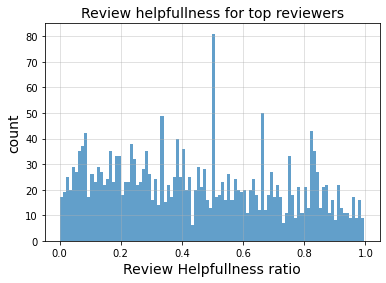

In [41]:
# review helpfulness distribution
top_reviewer_avg_data['Helpfulness Ratio'].hist(bins=100,label='review helpfullness top reviewers',alpha=0.7);

plt.xlabel('Review Helpfullness ratio',fontsize=14);
plt.ylabel('count',fontsize=14);

plt.grid(linewidth=0.5,alpha=0.75)

plt.title('Review helpfullness for top reviewers',fontsize=14);
plt.savefig('helpfullness_top_reviewer_dist.png')

Majority of people find top reviewer helpful

**Review helpfulness vs. review length for top reviewers**

In [42]:
top_reviewer_avg_data.head()

,Score,Helpfulness Ratio,Text_lenght,Sentiment,Text_new
UserId,,,,,
A101P2KHWCU0G6,2.038462,0.346154,132.153846,0.346154,26
A102LH0KD8SYHX,4.428571,0.285714,12.285714,1.285714,14
A106ZCP7RSXMRU,4.630435,0.798810,51.500000,1.065217,46
A10AFVU66A79Y1,3.390244,0.262834,65.292683,0.682927,41
A10C4O0Q0TWXOL,5.000000,0.519231,42.692308,1.000000,13


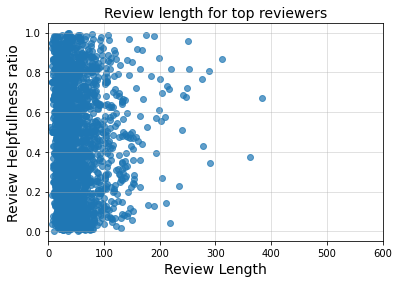

In [43]:
# review length vs helpfulness
plt.scatter(top_reviewer_avg_data['Text_lenght'],top_reviewer_avg_data['Helpfulness Ratio'],alpha=0.7);
plt.xlim(0,600);
plt.xlabel('Review Length',fontsize=14);
plt.ylabel('Review Helpfullness ratio',fontsize=14);
plt.grid(linewidth=0.5,alpha=0.75)

plt.title('Review length for top reviewers',fontsize=14);
plt.savefig('helpfullness_top_reviewer_length.png')

Users generally find top reviewer with more than 200 words length review helpful, longer review better feedback

**Review helpfulness vs. review count for top reviewers**

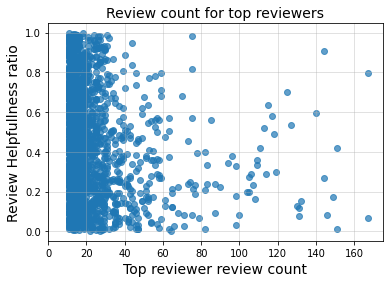

In [44]:
#review helpfulness vs. review count
plt.scatter(top_reviewer_avg_data['Text_new'],top_reviewer_avg_data['Helpfulness Ratio'],alpha=0.7);
plt.xlim(0,175);
plt.xlabel('Top reviewer review count',fontsize=14);
plt.ylabel('Review Helpfullness ratio',fontsize=14);

plt.grid(linewidth=0.5,alpha=0.75)
plt.title('Review count for top reviewers',fontsize=14);
plt.savefig('helpfullness_top_reviewer_count.png')

Top reviewers that write more frequent over 60 review (even though not many of them in dataset), receive very good feedback from community. If the review write between 1-30 words no trend observed though.

**Review frequency vs. review length for top reviewers**


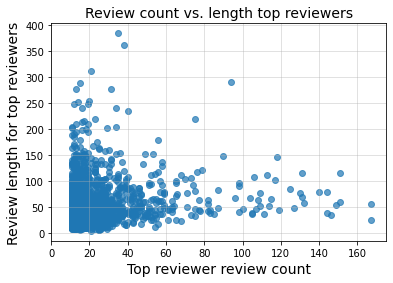

In [45]:
#revire count of top reviewers vs. review length
plt.scatter(top_reviewer_avg_data['Text_new'],top_reviewer_avg_data['Text_lenght'],alpha=0.7);
plt.xlim(0,175);

plt.xlabel('Top reviewer review count',fontsize=14);
plt.ylabel('Review length for top reviewers',fontsize=14);

plt.grid(linewidth=0.5,alpha=0.75)
plt.title('Review count vs. length top reviewers',fontsize=14);
plt.savefig('helpfullness_top_reviewer_length_count.png')

Interestingly the top reviewers that write more often do not write very long paragraphs above 200 words, while those that write longer have less than 20-30 review

**Review score/length/helfulness trend in time**

Here the impact of time on review score, length, and helpfulness is studied.

Data are grouped by score, as well as total count per month of each year from 1999 to 2012

In [46]:
# Divide the data by score and group for each month
grp_s1=dfreviews[dfreviews['Score']==1]
grp_s2=dfreviews[dfreviews['Score']==2]
grp_s3=dfreviews[dfreviews['Score']==3]
grp_s4=dfreviews[dfreviews['Score']==4]
grp_s5=dfreviews[dfreviews['Score']==5]

grp_date_1=grp_s1.groupby(by=['Time_ym']).count();
grp_date_2=grp_s2.groupby(by=['Time_ym']).count();
grp_date_3=grp_s3.groupby(by=['Time_ym']).count();
grp_date_4=grp_s4.groupby(by=['Time_ym']).count();
grp_date_5=grp_s5.groupby(by=['Time_ym']).count();

grp_date_1.reset_index(inplace=True); #to make it to column
grp_date_2.reset_index(inplace=True);
grp_date_3.reset_index(inplace=True);
grp_date_4.reset_index(inplace=True);
grp_date_5.reset_index(inplace=True);

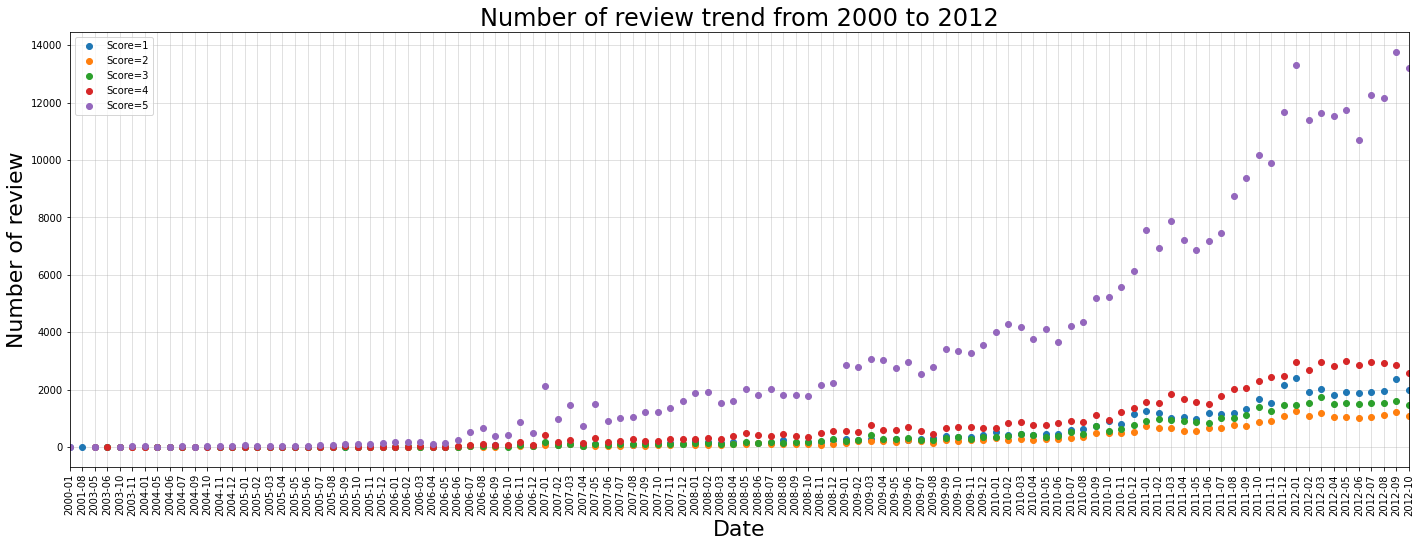

In [47]:
# review count by score for each month from 2000 to 2012
plt.figure(figsize=(24,8))

plt.plot_date(x=grp_date_1['Time_ym'],y=grp_date_1['Score'],label='Score=1');
plt.plot_date(x=grp_date_2['Time_ym'],y=grp_date_2['Score'],label='Score=2');
plt.plot_date(x=grp_date_3['Time_ym'],y=grp_date_3['Score'],label='Score=3');
plt.plot_date(x=grp_date_4['Time_ym'],y=grp_date_4['Score'],label='Score=4');
plt.plot_date(x=grp_date_5['Time_ym'],y=grp_date_5['Score'],label='Score=5');
plt.xticks(rotation=90);
plt.legend()
plt.grid(linewidth=0.5,alpha=0.75)
plt.xlim('2000-01','2012-10');
plt.xlabel('Date',fontsize=22)
plt.ylabel('Number of review',fontsize=22)
plt.title('Number of review trend from 2000 to 2012',fontsize=24);
plt.savefig('data_review_trend.png')
#grp_date

From the 2000 to 2006 there is limited review available on Amazon, however trend start to change suddenly after 2006, the total number of 5 star review show biggest surge among other scores, this seems a bit unusual and one might ask people generally are optimistic or most possibly there are unverified accounts that are boosting the seller inappropriately with fake reviews

Another interesting observation even though minimal, during January 2007,2008,2011 and 2012 slight increase in 5 start reviews are observed. Question is this slight increase due to cheerful holiday spirit?!

The 1 to 4 star review count gradual increase make more sense due to more customer become aware of Amazon services.

In [48]:
# average of helpfulness per month is calculated
grp_avg_date=dfreviews.groupby(by=['Time_ym']).mean()
grp_avg_date.reset_index(inplace=True);
grp_avg_date.head()

,Time_ym,Score,Helpfulness Ratio,Text_lenght,Sentiment
0,1999-10,5.0,0.000000,33.000,1.000
1,1999-12,5.0,0.125000,20.250,1.000
2,2000-01,3.5,0.434783,24.125,0.625
3,2000-02,4.0,0.666667,97.000,1.000
4,2000-06,5.0,0.400000,21.400,1.000


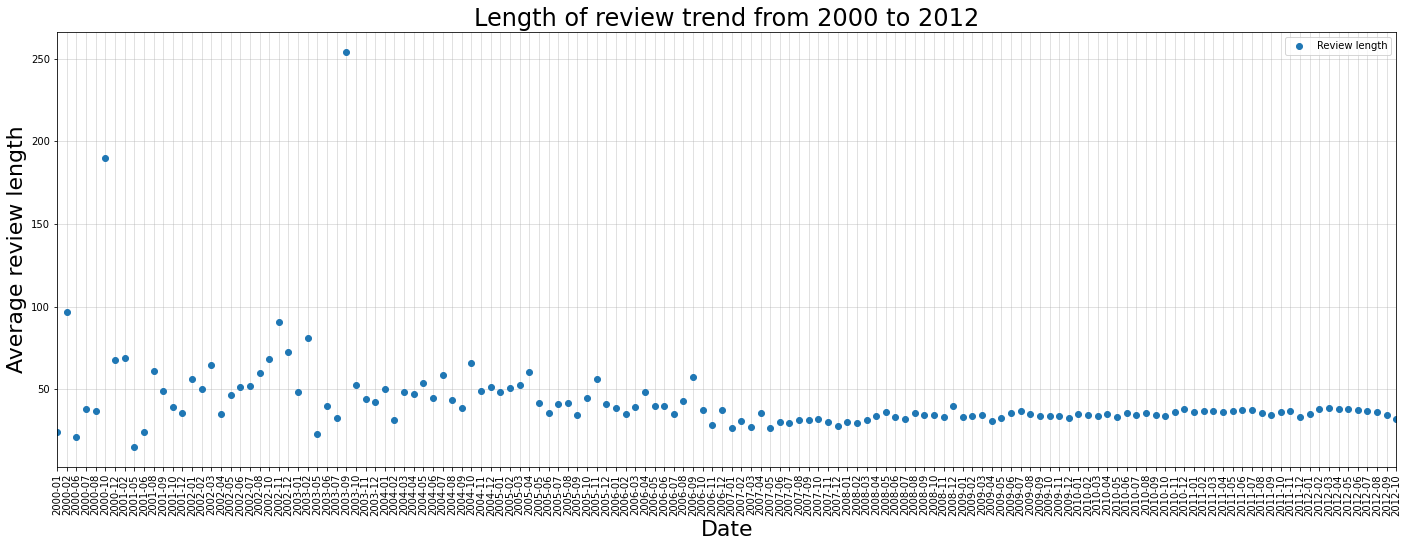

In [49]:
# average review length vs. time
plt.figure(figsize=(24,8))
plt.plot_date(x=grp_avg_date['Time_ym'],y=grp_avg_date['Text_lenght'],label='Review length');
plt.xticks(rotation=90);
plt.legend()
plt.grid(linewidth=0.5,alpha=0.75)
plt.xlim('2000-01','2012-10');
plt.xlabel('Date',fontsize=22)
plt.ylabel('Average review length',fontsize=22)
plt.title('Length of review trend from 2000 to 2012',fontsize=24);
plt.savefig('data_review_length_trend.png')
#stable review length

No special trend is observed, only seems that from 2000 to 2006 due to limited review available there is more standard deviation in the review length statistics

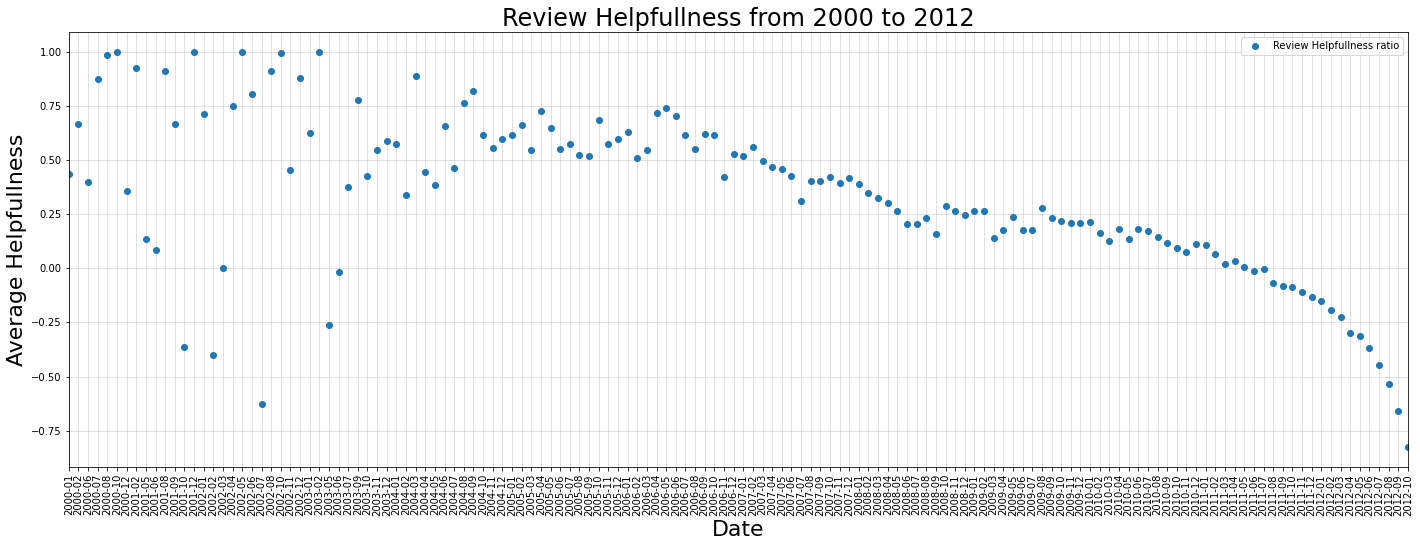

In [50]:
# review helpfulness vs time
plt.figure(figsize=(24,8))
plt.plot_date(x=grp_avg_date['Time_ym'],y=grp_avg_date['Helpfulness Ratio'],label='Review Helpfullness ratio');
plt.xticks(rotation=90);
plt.legend()
plt.grid(linewidth=0.5,alpha=0.75)
plt.xlim('2000-01','2012-10');
plt.xlabel('Date',fontsize=22)
plt.ylabel('Average Helpfullness',fontsize=22)
plt.title('Review Helpfullness from 2000 to 2012',fontsize=24);
plt.savefig('data_review_helpful_trend.png')

#drop can be due to visitor not getting time yet to check the reviews of 2012

No special trend is observed, only seems that later in 2012 slight drop in helpfulness observed, that can be associated with the review itself being new and read fewer time

**Sentiment Analysis**

In this section Machine learning analysis is performed on review text (now in a form of a list) and review score as positive or negative.

The first step is collecting words for all reviews, positive reviews and negative reviews separately in dictionary.

The most common words are checked in each postive and negative group.

Word polarity, which is ratio of a common word occurance in positive review vs, negative review is calculated and words with similar polarity are plotted.

**Creating word collector for postive/negative/neutral/all reviews**

In [51]:
# initialize counters for posiive, negative and all reviews
positive_reviews=Counter()
negative_reviews=Counter()
neutral_reviews=Counter()
total_reviews=Counter()

In [52]:
# get individual review, score (0/1/2) and actual score 1-5 from dataframe in the vector form
review_vec=dfreviews['Text_new']
score_vec=dfreviews['Sentiment']
actual_score_vec=dfreviews['Score']

**A Negative review**

In [53]:
# Negative review

for i,review in enumerate(review_vec):
    if(i>10 and i<16 and score_vec[i]==0 and actual_score_vec[i]!=3):
        print('Negative, Actual score =', actual_score_vec[i],', Review index = ',i,'\n')
        print(review)
        print(' \n')

Negative, Actual score = 1 , Review index =  12 

['cats', 'fans', 'food', 'cats', 'happily', 'eating', 'felidae', 'platinum', 'years', 'shape', 'food', 'different', 'tried', 'food', 'first', 'bowls', 'bowls', 'full', 'kitties', 'touch', 'food', 'noticed', 'similar', 'reviews', 'related', 'formula', 'changes', 'past', 'unfortunately', 'need', 'find', 'food', 'cats']
 



**A positive review**

In [54]:
for i,review in enumerate(review_vec):
    
    if(i>11 and i<15 and score_vec[i]==1 and actual_score_vec[i]==5):
        print('Positive, Actual score = ',actual_score_vec[i],', Review index = ',i,'\n')
        print(review)
        print(' \n')

Positive, Actual score =  5 , Review index =  14 

['strawberry', 'twizzlers', 'yummy', 'strawberry', 'twizzlers', 'guilty', 'pleasure', 'yummy', 'pounds', 'around']
 




**collection of words are added**

In [55]:
# postive/negative/neutral and total reviews per each review one by one

for i in tqdm(range(len(review_vec))):
    
    try:
        for word in review_vec[i]:        
            total_reviews[word] += 1

            if(score_vec[i]==0):
                negative_reviews[word] += 1

            elif(score_vec[i]==1):
                positive_reviews[word] += 1

            elif(score_vec[i]==2):
                neutral_reviews[word] += 1
            else:
                print(total_reviews[word])
    except:   
        continue

  0%|          | 0/560761 [00:00<?, ?it/s]

**Most common words in negative reviews**

In [56]:
negative_FreqDist = FreqDist(negative_reviews)
negative_FreqDist.most_common(20)


[('like', 46843),
 ('taste', 35313),
 ('would', 26009),
 ('coffee', 24459),
 ('flavor', 22006),
 ('food', 20982),
 ('even', 16215),
 ('much', 14261),
 ('really', 14222),
 ('tried', 11729),
 ('time', 11595),
 ('first', 11573),
 ('bought', 11162),
 ('made', 11157),
 ('better', 10715),
 ('also', 9982),
 ('water', 9780),
 ('price', 9446),
 ('could', 9374),
 ('tastes', 9274)]

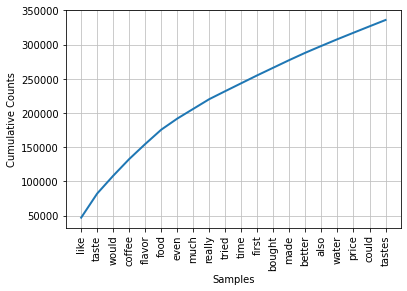

In [57]:
# Frequency distribution plot for negative reviews
negative_FreqDist.plot(20, cumulative=True)

**Wordcloud — Negative Sentiment**

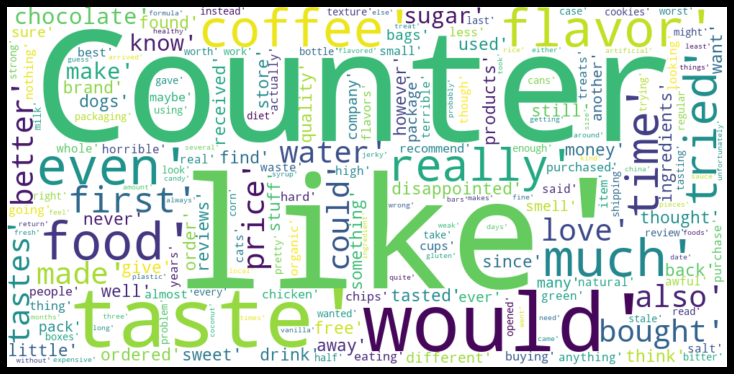

In [58]:
generate_word_cloud(negative_reviews)

**Most common words in positive reviews**

In [59]:
# top 20 most common words in positive reviews
positive_FreqDist = FreqDist(positive_reviews)
positive_FreqDist.most_common(20)

[('like', 186577),
 ('coffee', 144753),
 ('love', 134216),
 ('taste', 128234),
 ('flavor', 116139),
 ('food', 103395),
 ('best', 98693),
 ('would', 80046),
 ('really', 78502),
 ('much', 68800),
 ('price', 68782),
 ('also', 67586),
 ('little', 66955),
 ('time', 66191),
 ('find', 61205),
 ('well', 59487),
 ('tried', 58132),
 ('make', 56823),
 ('better', 56137),
 ('delicious', 55644)]

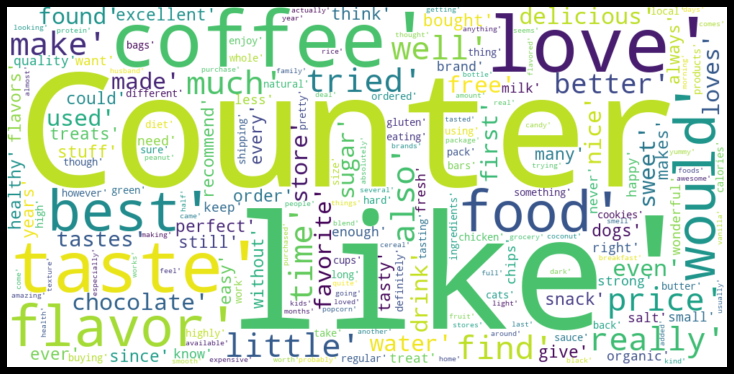

In [60]:
generate_word_cloud(positive_reviews)

In [61]:
# top 20 most common words in neutral reviews
neutral_FreqDist = FreqDist(neutral_reviews)
neutral_FreqDist.most_common(20)

[('like', 27283),
 ('taste', 21424),
 ('coffee', 19140),
 ('flavor', 17691),
 ('would', 15297),
 ('much', 10890),
 ('really', 10213),
 ('better', 8868),
 ('food', 8801),
 ('little', 8683),
 ('water', 7564),
 ('price', 6882),
 ('time', 6765),
 ('love', 6697),
 ('also', 6628),
 ('think', 6389),
 ('first', 6040),
 ('however', 5845),
 ('sweet', 5845),
 ('well', 5753)]

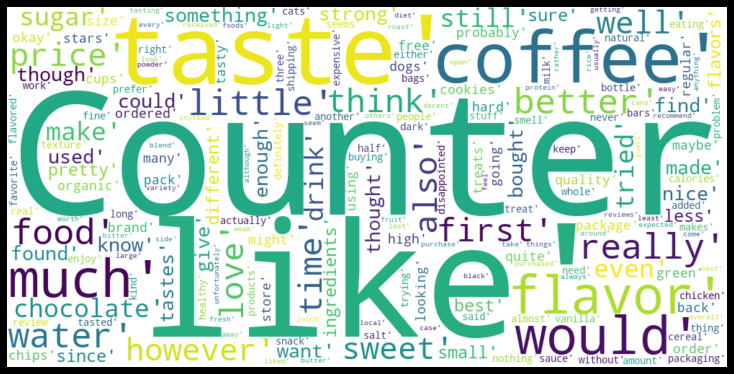

In [62]:
generate_word_cloud(neutral_reviews)

**Creating collector for high polarity words (high pos/neg count)**

In [63]:
# This counter only consider words ratio in postive vs negative review,
#if word not in negative collection a "1" is added to avoid NaN
# to avoidvery big or small ratio, a log value is saved

counter_pos_neg=Counter()

#words called in for over 100 times in whole reviews

for word,count in tqdm(total_reviews.most_common()):
    if(count>100):
        try: 
            counter_pos_neg[word]=np.log(positive_FreqDist[word]/float(negative_FreqDist[word]+1))
        except:
            continue

  0%|          | 0/110236 [00:00<?, ?it/s]

**Top most polar words**

Top 40 are most positive polar appear in more postive reviews, bottom 40 polar are most negative, appear more in negative reviews

In [64]:
dict_top_pos=dict(counter_pos_neg.most_common(40))
dict_top_neg=dict(counter_pos_neg.most_common()[:-40:-1])

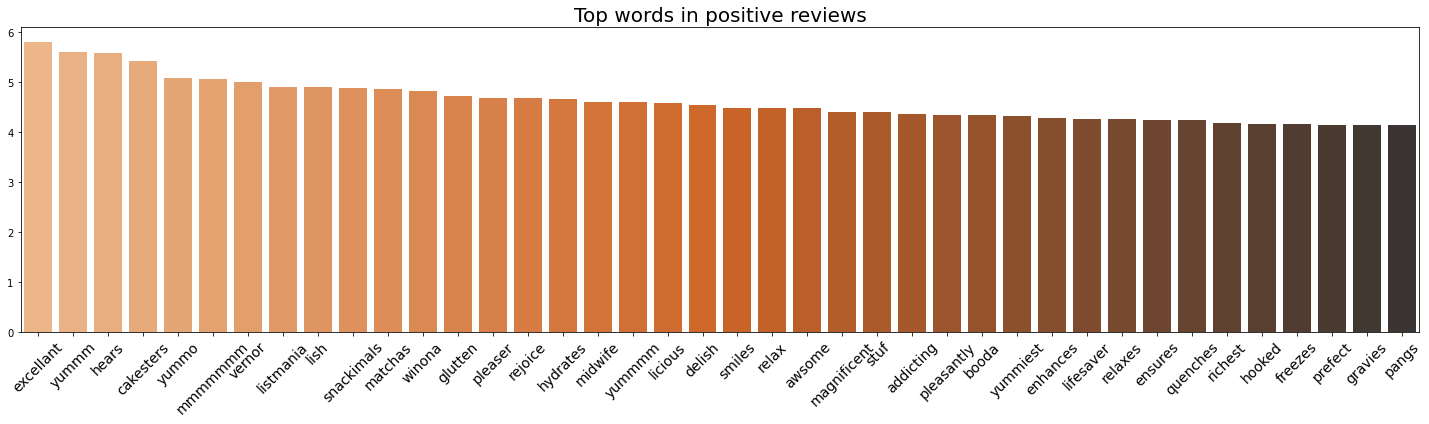

In [65]:
# Top 40 most positive polar


# plt.autolayout : True
# plt.tight_layout();
plt.figure(figsize=(20,6))
sns.barplot(list(dict_top_pos.keys()), list(dict_top_pos.values()), palette="Oranges_d")
plt.xticks(rotation=45,fontsize=14);
plt.title('Top words in positive reviews',fontsize=20);
plt.tight_layout();

The bundle of these polar words very much make sense, with words from "exellant", "yummm", to "smile" and "relax" show postive sentiment

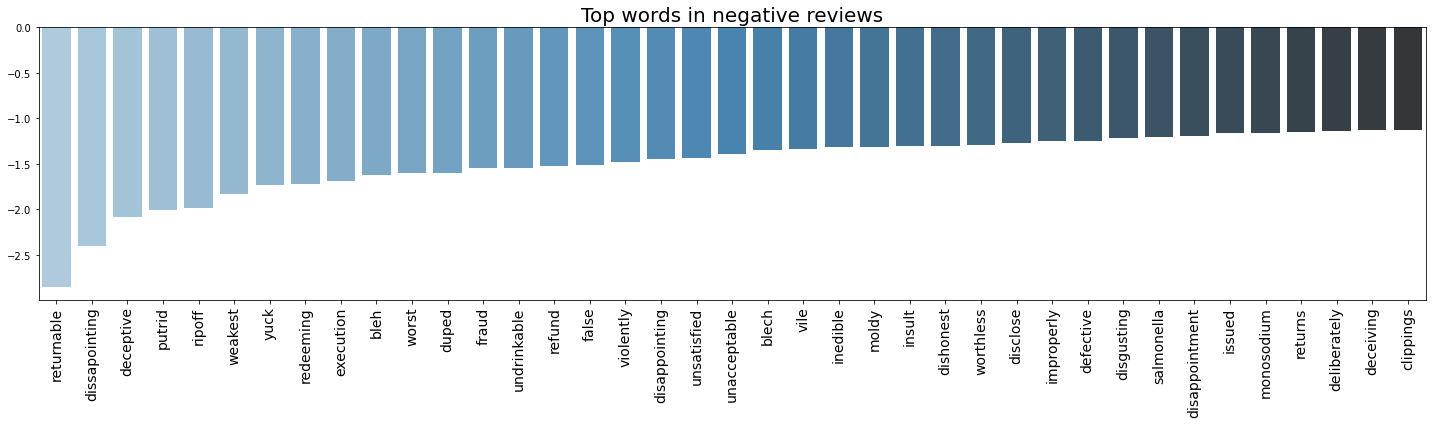

In [66]:
# Top 40 most negative polar

plt.figure(figsize=(20,6))
sns.barplot(list(dict_top_neg.keys()), list(dict_top_neg.values()), palette="Blues_d")
plt.xticks(rotation=90,fontsize=14);
plt.title('Top words in negative reviews',fontsize=20);
plt.tight_layout();
plt.savefig('word__freq_neg_rev.png')

The bundle of these polar words also make sense, with words from "returnable", "deceptive", to "ripoff" and "yuck" show more negative sentiments.

Mean: 1.5696578106791474


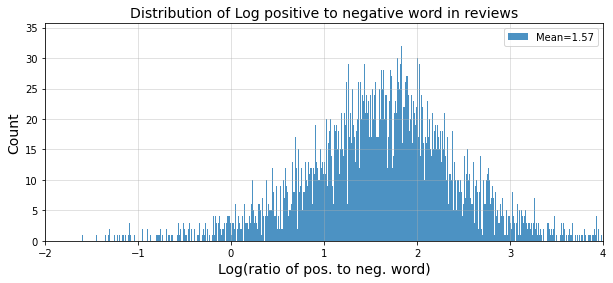

In [67]:
# polarity value distribution
print('Mean:',np.mean(list(set(counter_pos_neg.values()))))
plt.figure(figsize=(10,4));
plt.hist(counter_pos_neg.values(),bins=2000,label='Mean=1.57',alpha=0.8);
plt.xlim(-2,4)

plt.xlabel('Log(ratio of pos. to neg. word)',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.title('Distribution of Log positive to negative word in reviews',fontsize=14)
plt.grid(linewidth=0.5,alpha=0.75)
plt.legend(loc='upper right');
plt.savefig('distribution_log_pos_neg_word_review.png')

Generally it is expected that polarity values center around one with more Gaussian distribution but due to large number of positive reviews "5' star review the center is actually shifted to 1.57.

In [68]:
#dictionary count in postive, negative, ad total words
print(len(counter_pos_neg.most_common()),len(positive_FreqDist.most_common()),len(negative_FreqDist.most_common()),len(neutral_FreqDist.most_common()),len(total_reviews.most_common()))

9363 95665 44232 32793 110236


In [69]:
print('%0.2f' %counter_pos_neg['neutral'],'%0.2f' %counter_pos_neg['diet'],'%0.2f' %counter_pos_neg['awful'],'%0.2f' %counter_pos_neg['food'])

2.02 1.60 -1.10 1.59


#**Balance dataset**

In [70]:
dfreviews.head()

,ProductId,UserId,Score,Summary_Text,Time_ymd,Time_ym,Helpfulness Ratio,Text_new,Text_lenght,Sentiment
0,B001E4KFG0,A3SGXH7AUHU8GW,5,Good Quality Dog Food I have bought several of...,2011-04-27,2011-04,1.0,"[quality, food, bought, several, vitality, can...",21,1
1,B00813GRG4,A1D87F6ZCVE5NK,1,Not as Advertised Product arrived labeled as J...,2012-09-07,2012-09,-1.0,"[advertised, arrived, labeled, jumbo, salted, ...",17,0
2,B000LQOCH0,ABXLMWJIXXAIN,4,"""Delight"" says it all This is a confection tha...",2008-08-18,2008-08,1.0,"[delight, says, confection, around, centuries,...",40,1
3,B000UA0QIQ,A395BORC6FGVXV,2,Cough Medicine If you are looking for the secr...,2011-06-13,2011-06,1.0,"[cough, medicine, looking, secret, ingredient,...",18,0
4,B006K2ZZ7K,A1UQRSCLF8GW1T,5,Great taffy Great taffy at a great price. The...,2012-10-21,2012-10,-1.0,"[taffy, taffy, price, wide, assortment, yummy,...",12,1


In [71]:
# Distribution of reviews per sentimen type
# 0 = Negative, 
# 1 = Positive, 
# 2 = Neutral
dfreviews['Sentiment'].value_counts()

1    437629
0     81106
2     42026
Name: Sentiment, dtype: int64

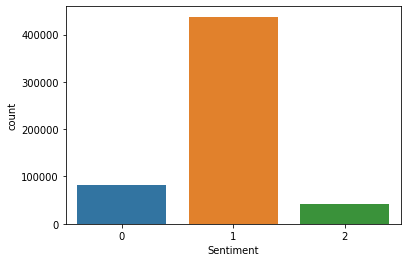

In [72]:
# Visualize the distribution of reviews per sentimen type
sns.countplot(dfreviews['Sentiment'])

As the distribusion of reviews is not balanced for all three types of sentiments, there is a need to balance it. So that all the sentiment classes have equal number of records.

Oversampling and undersampling are the ways to rebalance the dataset.
But, as there is hude gap between number of records for class 1 (positive) and the number of records for class 0 (negative) and 2 (neutral).

We will peform oversampling for the minority classes. So that there will equal number of reviews for positive, negative and neutral sentiments.

In [73]:
# Review text is in a list form
dfreviews['Text_new']

0         [quality, food, bought, several, vitality, can...
1         [advertised, arrived, labeled, jumbo, salted, ...
2         [delight, says, confection, around, centuries,...
3         [cough, medicine, looking, secret, ingredient,...
4         [taffy, taffy, price, wide, assortment, yummy,...
                                ...                        
568449    [without, sesame, chicken, better, resturants,...
568450    [disappointed, disappointed, flavor, chocolate...
568451    [perfect, maltipoo, stars, small, give, traini...
568452    [favorite, training, reward, treat, best, trea...
568453    [honey, satisfied, advertised, cereal, vinegar...
Name: Text_new, Length: 560761, dtype: object

In [74]:
# Join the review text to convert to an array of string
dfreviews['Text_new'].apply(lambda x: ' '.join([word for word in x])).to_numpy()

array(['quality food bought several vitality canned food products found quality looks like stew processed meat smells better labrador finicky appreciates better',
       'advertised arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent jumbo',
       'delight says confection around centuries light pillowy citrus gelatin nuts case filberts tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
       ...,
       'perfect maltipoo stars small give training session tried train ceaser treats made puppy hyper compare ingredients know little stars basic food ingredients without preservatives food coloring sweet potato flavor also make hand smell like food',
       'favorite training reward treat best treats training rewarding grooming lower calories loved doggies sweet potatoes seem favo

In [75]:
# Split amazon review dataset into tarin and test dataset
from sklearn.model_selection import train_test_split
X = dfreviews['Text_new'].apply(lambda x: ' '.join([word for word in x])).to_numpy()
y = dfreviews['Sentiment'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=True, stratify=y, random_state=42)


In [76]:
# Convert the collection of text documents to a matrix of token counts
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [77]:
# Learn training data vocabulary, then use it to create a document-term matrix
X_train_dtm = vect.fit_transform(X_train)

# Examine the document-term matrix
X_train_dtm

<448608x100625 sparse matrix of type '<class 'numpy.int64'>'
	with 13312792 stored elements in Compressed Sparse Row format>

In [78]:
# Transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<112153x100625 sparse matrix of type '<class 'numpy.int64'>'
	with 3316215 stored elements in Compressed Sparse Row format>

In [79]:
# Over sampling using SMOTE
from imblearn.over_sampling import SMOTE
oversample = SMOTE(random_state=42)
X_train, y_train = oversample.fit_resample(X_train_dtm, y_train.ravel())

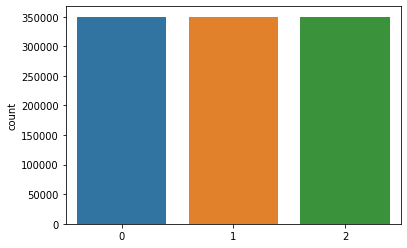

In [80]:
# Visualize the distributino of reviews again. 
# After oversampling, all the sentiments have equal number of reviews
sns.countplot(y_train)

#**Building models**

In [81]:
dfResults = pd.DataFrame(columns=['Model','Accuracy', 'Precision','Recall','F1 score','Confusion matrix'])
dfResults

,Model,Accuracy,Precision,Recall,F1 score,Confusion matrix


In [82]:
# save the model evaluation in dataframe 
def SaveResults(modelname, accuracy, precision, recall, F1_score, confusion_matrix):
  global dfResults
  dfResults.style.hide_index()
  if(dfResults[dfResults['Model']==modelname] is not np.empty):
    dfResults.drop(dfResults.loc[dfResults['Model']==modelname].index, inplace=True)
  new_results = {'Model': modelname, 
             'Accuracy': accuracy, 
             'Precision':precision, 
             'Recall':recall, 
             'F1 score':F1_score, 
             'Confusion matrix':confusion_matrix}
  #append row to the dataframe
  dfResults= dfResults.append(new_results, ignore_index=True)


# Evaluate the model based on accuray, precision, recall, F1 and ROC score
def evaluate_model(x_test, y_true, model,modelname):
  from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score, roc_auc_score ,classification_report, RocCurveDisplay
  y_pred = model.predict(x_test)
  accuracy = accuracy_score(y_true, y_pred)
  # print('Accuracy: {:.2f}%'.format(accuracy))
  precision = precision_score(y_true, y_pred,average='weighted')
  print('Precision: {:.2f}%'.format(precision))
  recall = recall_score(y_true, y_pred, average='weighted')
  print('Recall: {:.2f}%'.format( recall))
  f1 = f1_score(y_true, y_pred,average='weighted')
  print('Accuracy: {:.2f}%'.format(accuracy))

 
  # confusion matrix
  matrix = confusion_matrix(y_true, y_pred)
  print("Confusion metrics \n",matrix)
  print('**********************************************************')
  print('*****************  Classification Report  ****************')
  print('**********************************************************')
  print(classification_report(y_true,y_pred))
  SaveResults(modelname,accuracy,precision,recall,f1,matrix)


**MultinomialNB Model**

In [83]:
#  Import
from sklearn.naive_bayes import MultinomialNB

#  Instantiate a Multinomial Naive Bayes model
nb = MultinomialNB()

#  Train the model 
nb.fit(X_train, y_train)

MultinomialNB()

In [84]:
# Evaluate model
evaluate_model(X_test_dtm, y_test, nb, 'Naive Bayes')

Precision: 0.84%
Recall: 0.79%
Accuracy: 0.79%
Confusion metrics 
 [[11417  2066  2738]
 [ 4712 72570 10245]
 [ 1835  2428  4142]]
**********************************************************
*****************  Classification Report  ****************
**********************************************************
              precision    recall  f1-score   support

           0       0.64      0.70      0.67     16221
           1       0.94      0.83      0.88     87527
           2       0.24      0.49      0.32      8405

    accuracy                           0.79    112153
   macro avg       0.61      0.68      0.62    112153
weighted avg       0.84      0.79      0.81    112153



From the evaluation matrics we can see that the accuracy of the model is 79%.
However, the f1-score for three classes tells a different story. f1-score of nutral reviews is 32% which is way too less than f1-score of positive and negative reviews. We tried to balance the dataset with oversampling technique, but the model learned to predict the positive sentiments more accuratly as compared to other negative and neutral sentiments.

**Logistic Regression Model**

In [85]:
#  Import
from sklearn.linear_model import LogisticRegression

# Instantiate a Logistic Regression model
lr_model = LogisticRegression()

# Train the model
lr_model.fit(X_train, y_train)

LogisticRegression()

In [86]:
# Evaluate model
evaluate_model(X_test_dtm, y_test, lr_model, 'Logistic Regression')

Precision: 0.86%
Recall: 0.82%
Accuracy: 0.82%
Confusion metrics 
 [[12300  1799  2122]
 [ 4276 75800  7451]
 [ 1735  2353  4317]]
**********************************************************
*****************  Classification Report  ****************
**********************************************************
              precision    recall  f1-score   support

           0       0.67      0.76      0.71     16221
           1       0.95      0.87      0.91     87527
           2       0.31      0.51      0.39      8405

    accuracy                           0.82    112153
   macro avg       0.64      0.71      0.67    112153
weighted avg       0.86      0.82      0.84    112153



LSTM 

In [87]:
#Read the data
dfreviews_LSTM=dfreviews[['Text_new','Sentiment']]
dfreviews_LSTM.head()

,Text_new,Sentiment
0,"[quality, food, bought, several, vitality, can...",1
1,"[advertised, arrived, labeled, jumbo, salted, ...",0
2,"[delight, says, confection, around, centuries,...",1
3,"[cough, medicine, looking, secret, ingredient,...",0
4,"[taffy, taffy, price, wide, assortment, yummy,...",1


In [88]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

I will split the dataset into two datasets and will perform oversampling on one of the datasets. Oversampeled dataset will be used for training the models and other dataset will be used for testing.

In [89]:
dfreviews_LSTM['Text_new'] = dfreviews_LSTM['Text_new'].apply(lambda x: ' '.join([word for word in x]))
train, test = train_test_split(dfreviews_LSTM, test_size=0.5, shuffle=True,  random_state=42)
print(train.shape)
print(test.shape)

(280380, 2)
(280381, 2)


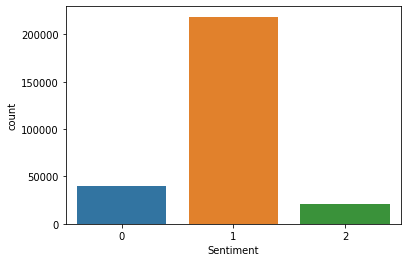

In [90]:
sns.countplot(train['Sentiment'])

In [91]:
train['Sentiment'].value_counts()

1    218758
0     40440
2     21182
Name: Sentiment, dtype: int64

This countplot shows that data is unbalanced. We will perform oversampling for training dataset.

In [92]:
neutral_review = train['Sentiment'] == 2
neutral_reviewnum_to_oversample = (train['Sentiment'] == 1).sum() - neutral_review.sum()
df_neutral_oversample = train[neutral_review].sample(n=neutral_reviewnum_to_oversample, replace=True, random_state=42)

negative_review = train['Sentiment'] == 0
negative_reviewnum_to_oversample = (train['Sentiment'] == 1).sum() - negative_review.sum()
df_negative_oversample = train[negative_review].sample(n=negative_reviewnum_to_oversample, replace=True, random_state=42)

df_train_oversample = pd.concat([train, df_neutral_oversample, df_negative_oversample])
df_train_oversample['Sentiment'].value_counts()

1    218758
2    218758
0    218758
Name: Sentiment, dtype: int64

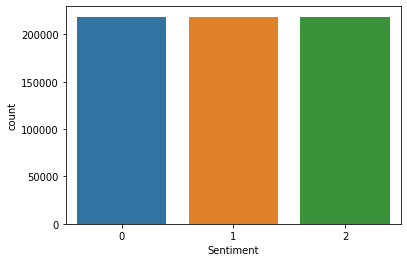

In [93]:
sns.countplot(df_train_oversample['Sentiment'])

In [94]:
X = df_train_oversample['Text_new']
y = df_train_oversample['Sentiment']

X_train_lstm, X_val_lstm, y_train_lstm, y_val_lstm = train_test_split(X,y, test_size=0.2, shuffle=True, stratify=y, random_state=42)

To perform the tokenization of training data, we need to specify the vocabulary size which indicates the number of words having a maximum frequency count.

we will consider only the first 10000 words based on their frequency in the entire training data

In [95]:
vocab_size = 10000
oov_tok = "<OOV>"
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

After defined the hyperparameters for Tokenizer(), we need to fit them on the training data using fit_on_texts().

In [96]:
tokenizer.fit_on_texts(X_train_lstm)
print("Number of Documents: ", tokenizer.document_count)
print("Number of Words: ", tokenizer.num_words)

Number of Documents:  525019
Number of Words:  10000


We have tokenized the entire text corpus, now we need to convert each textual review into a numerical sequence using the fitted tokenizer.

In [97]:
train_sequences = tokenizer.texts_to_sequences(X_train_lstm)
print(train_sequences[0])

[367, 154, 381, 55, 298, 1759, 3, 348, 18, 78, 2, 154, 84, 55, 1030, 146]


Each review in the training data is now converted into a numerical sequence which can be fed into a mathematical model for further training purposes.

Also we need to limit the sequence lengths to a constant value for each review. We will specify a nominal sequence length of 200 for each review

In [98]:
sequence_length = 200
train_padded = pad_sequences(train_sequences, maxlen=sequence_length, padding='post', truncating='post')

The numerical sequences having lengths greater than 200 will be truncated at the end, whereas the ones having lengths smaller than 200 will be padded with zeros at the end.

Once we have done pre-processing on the train data, we need to repeat the same steps for the test data.

In [99]:
# pre-processing on the test data
test_sequences = tokenizer.texts_to_sequences(X_val_lstm)
test_padded = pad_sequences(test_sequences, maxlen=sequence_length, padding='post', truncating='post')

LSTM model consists of multiple layers, each one taking input from the previous one and advancing output to the next one. The first layer takes the numerical sequences as input, and the last layer gives the prediction label as the output.

We will add Embedding, Bidirectional LSTM layer,Dense layer and output layer in the model.  

One advantage of using bidirectional LSTM is that it remembers output from past to future as well as from future to past. This technique can result in more robust models

The output layer will output the probability that an input belongs to 1 (positive) or 0 (Negative) or 2 (neutral) using the softmax filter.

In [100]:
CLASSES = [0,1,2]
model = Sequential()

# Firstly, we will add an embedding layer which will convert each word into a dense vector of embedding dimensions.
embedding_dim = 16
model.add(Embedding(vocab_size, embedding_dim, input_length=sequence_length))
lstm_out = 32

# Specify the Bidirectional() layer and the LSTM layer with a specified unit size
model.add(Bidirectional(LSTM(lstm_out)))

# Add a fully connected layer having 10 units and ‘relu’ activation
model.add(Dense(len(CLASSES), activation='relu'))

# Add an output layer having only 3 units and 'softmax' activation. 
model.add(Dense(3, activation='softmax'))

In [101]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
 dense_1 (Dense)             (None, 3)                 12        
                                                                 
Total params: 172,751
Trainable params: 172,751
Non-trainable params: 0
_________________________________________________________________
None


In [102]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

I am using loss='sparse_categorical_crossentropy' as the target variable is not one hot encoded. Instead it is kind of lable encoded with values from 0,1 and 2.

In [103]:
history = model.fit(train_padded, y_train_lstm, epochs=10, validation_data=(test_padded, y_val_lstm), shuffle=True, batch_size = 64)

Epoch 1/10
8204/8204 [==============================] - 173s 20ms/step - loss: 0.5858 - accuracy: 0.7549 - val_loss: 0.4431 - val_accuracy: 0.8374
Epoch 2/10
8204/8204 [==============================] - 165s 20ms/step - loss: 0.3733 - accuracy: 0.8699 - val_loss: 0.3406 - val_accuracy: 0.8867
Epoch 3/10
8204/8204 [==============================] - 162s 20ms/step - loss: 0.2822 - accuracy: 0.9081 - val_loss: 0.2755 - val_accuracy: 0.9120
Epoch 4/10
8204/8204 [==============================] - 165s 20ms/step - loss: 0.2228 - accuracy: 0.9292 - val_loss: 0.2334 - val_accuracy: 0.9272
Epoch 5/10
8204/8204 [==============================] - 164s 20ms/step - loss: 0.1806 - accuracy: 0.9426 - val_loss: 0.2019 - val_accuracy: 0.9351
Epoch 6/10
8204/8204 [==============================] - 161s 20ms/step - loss: 0.1487 - accuracy: 0.9527 - val_loss: 0.1935 - val_accuracy: 0.9404
Epoch 7/10
8204/8204 [==============================] - 159s 19ms/step - loss: 0.1251 - accuracy: 0.9611 - val_loss: 0

In [104]:
# Trainm metrics per epoch
metrics_df = pd.DataFrame(history.history)
print(metrics_df)

       loss  accuracy  val_loss  val_accuracy
0  0.585788  0.754860  0.443082      0.837446
1  0.373307  0.869868  0.340600      0.886694
2  0.282189  0.908131  0.275474      0.912041
3  0.222823  0.929237  0.233400      0.927180
4  0.180602  0.942646  0.201888      0.935065
5  0.148738  0.952676  0.193550      0.940353
6  0.125103  0.961108  0.166149      0.950379
7  0.105149  0.967790  0.157618      0.954386
8  0.091551  0.972233  0.154394      0.957236
9  0.080297  0.975776  0.136226      0.962836


The train metrics shows that the accuracy of the model for train data is 97% and for validation data it is 96%. The results looks fine as there is lessgap between train and test metrics, which shows that there is less bias and less variance.

The loss for train is 7% and for validation data it is 13%. I tuned the batch_size from 32 to 64 and 128.  Batch size of 64 gave almost same results as 32. So, I kept it to 64. 

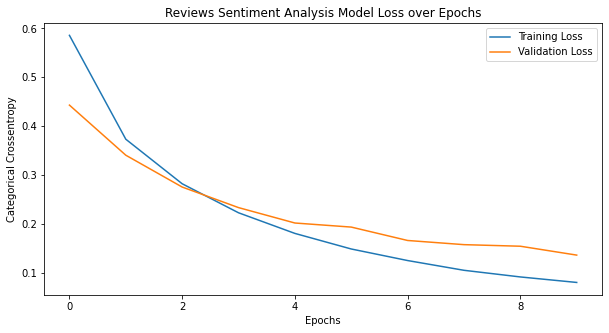

In [105]:
# Plot loss
plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.loss)
plt.plot(metrics_df.index, metrics_df.val_loss)
plt.title('Reviews Sentiment Analysis Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Categorical Crossentropy')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

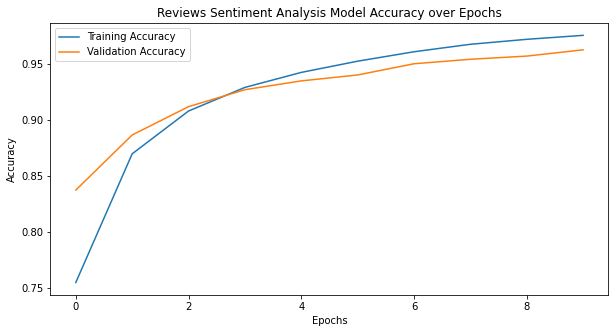

In [106]:
# Plot accuracy
plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.accuracy)
plt.plot(metrics_df.index, metrics_df.val_accuracy)
plt.title('Reviews Sentiment Analysis Model Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

**Evaluate the Model on Test dataset**

In [107]:
# Prepare test dataset
X_test = test['Text_new']
y_test = test['Sentiment']

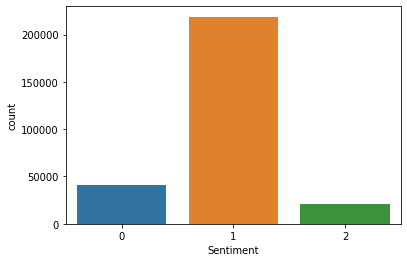

In [108]:
# Test data distribution for different sentiment types
sns.countplot(test['Sentiment'])

In [109]:
# Test data value counts for different sentiment types
test['Sentiment'].value_counts()

1    218871
0     40666
2     20844
Name: Sentiment, dtype: int64

In [110]:
# Prepare test dataset
testsequences = tokenizer.texts_to_sequences(X_test)
testpadded = pad_sequences(testsequences, maxlen=sequence_length, padding='post', truncating='post')

In [111]:
# Get predictions on test dataset
Y_pred = model.predict(testpadded, batch_size = 64)

4381/4381 [==============================] - 36s 8ms/step


In [112]:
# Evaluate the model performance on test dataset
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score, roc_auc_score ,classification_report, RocCurveDisplay

y_pred = np.argmax(Y_pred, axis=1)
accuracy = accuracy_score(y_test, y_pred)
# print('Accuracy: {:.2f}%'.format(accuracy))
precision = precision_score(y_test, y_pred,average='weighted')
print('Precision: {:.2f}%'.format(precision))
recall = recall_score(y_test, y_pred, average='weighted')
print('Recall: {:.2f}%'.format( recall))
f1 = f1_score(y_test, y_pred,average='weighted')
print('F1 score: {:.2f}%'.format( f1))
print('Accuracy: {:.2f}%'.format(accuracy))
# print(classification_report(df_test['true'], df_test['pred']))

 
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print("Confusion metrics \n",matrix)
print('**********************************************************')
print('*****************  Classification Report  ****************')
print('**********************************************************')
print(classification_report(y_test,y_pred))
SaveResults("LSTM",accuracy,precision,recall,f1,matrix)

Precision: 0.88%
Recall: 0.87%
F1 score: 0.87%
Accuracy: 0.87%
Confusion metrics 
 [[ 31525   5471   3670]
 [  8327 202480   8064]
 [  4114   6112  10618]]
**********************************************************
*****************  Classification Report  ****************
**********************************************************
              precision    recall  f1-score   support

           0       0.72      0.78      0.74     40666
           1       0.95      0.93      0.94    218871
           2       0.48      0.51      0.49     20844

    accuracy                           0.87    280381
   macro avg       0.71      0.74      0.72    280381
weighted avg       0.88      0.87      0.87    280381



**Compare the above classifiers models according to Accuracy, Precision, Recall, F1-Score, and ROC**

In [113]:
# Display the records for all the calssifiers
dfResults.head()

,Model,Accuracy,Precision,Recall,F1 score,Confusion matrix
0,Naive Bayes,0.785793,0.844962,0.785793,0.809121,"[[11417, 2066, 2738], [4712, 72570, 10245], [1..."
1,Logistic Regression,0.824026,0.860342,0.824026,0.838488,"[[12300, 1799, 2122], [4276, 75800, 7451], [17..."
2,LSTM,0.872466,0.877692,0.872466,0.874780,"[[31525, 5471, 3670], [8327, 202480, 8064], [4..."


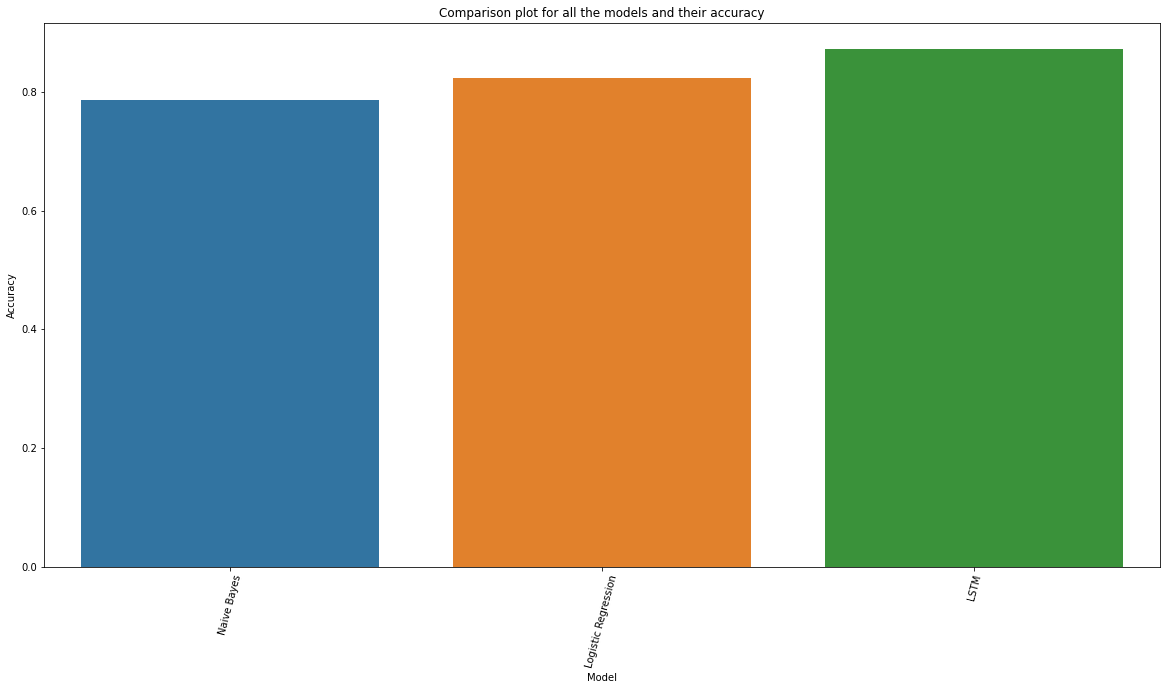

In [114]:
# Visualize the matrics for all the models
plt.figure(figsize=(20,10))
ax= sns.barplot(x = dfResults.Model,y = dfResults.Accuracy, data=dfResults)

ax.set_xticklabels(dfResults.Model,rotation = 75)
ax.set_title('Comparison plot for all the models and their accuracy')
plt.show()

From the above results we can see that LSTM model has the highets accuracy of 87% as compared to Logistic regression and Naive Bayes.
We will save the LSTM model and try to predict the sentiment of the random text provided.

**Save the best Model with pickle**

In [115]:
# save model
model.save('final_model.h5')

In [116]:
review = 'Not as Advertised Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo"'
#vectorizing the review by the pre-fitted tokenizer instance
review = tokenizer.texts_to_sequences(review)
#padding the review to have exactly the same shape as embedding input
review = pad_sequences(review, maxlen=sequence_length, dtype='int32', value=0)


In [117]:
from keras.models import load_model
model = load_model('final_model.h5')
sentiment = model.predict(review)[0]

if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")
elif (np.argmax(sentiment) == 2):
    print("neutral")

7/7 [==============================] - 1s 9ms/step
positive


The predicted class for the text is positive, which seems correct as the provided review text.

**Conclusion**

The models used to solve the problem "Naive Bayes" , "Logistic regression" and 
Long short-term memory (LSTM).
LSTM has the highest accuracy of 87% and this shows that the LSTM deep learning model with bidirectional layer is the best approach for analysing the sentiments of customer reviews.

As our goal was to build an automated model to predict the customer's sentiments based on the review text available online, It could be said the LSTM model could be used to predict the sentiments. 

**Suggestions**
There could be some other models like BERT which could be explored for the purpose, however that could increase the scope of the project.